# Attack On Titan Netwtork

In [ ]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import scipy as sp
import seaborn as sns
import powerlaw
from node2vec import Node2Vec
import random
import matplotlib.pyplot as plt
import numpy as np
from cdlib import algorithms

### Data import

In [2]:
# 1) Assign the path to the JSON file
DATA_PATH = "/Users/michelecoaro/Documents/GitHub/AOT_Network/Data/characters.json"

# 2) Loading the JSON data into a pandas DataFrame
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 3) Normalize the JSON data into a DataFrame
df = pd.json_normalize(data) 
print("Original DataFrame shape:", df.shape)

# 4) Display small sample to understand df structure
df.head(3)

Original DataFrame shape: (201, 16)


,id,name,img,alias,species,gender,age,height,relatives,birthplace,residence,status,occupation,groups,roles,episodes
0,1,Armin Arlelt,https://static.wikia.nocookie.net/shingekinoky...,[Colossal Titan],"[Human, Intelligent Titan]",Male,19,60 m (Colossal Titan form),"[{'family': 'Arlelt family', 'members': ['Unna...",Shiganshina District,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,https://static.wikia.nocookie.net/shingekinoky...,[],[Human],Female,19,unknown,"[{'family': 'Ackermann family', 'members': ['U...",Shiganshina District Outskirts? → Shiganshina ...,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,https://static.wikia.nocookie.net/shingekinoky...,[Horse face],[Human],Male,19,unknown,"[{'family': 'Kirschtein family', 'members': ['...",Trost District,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


### Data Cleaning

In [3]:
# 1) I only want to keep the following columns
columns_to_keep = [
    'id', 
    'name', 
    'alias', 
    'species', 
    'groups', 
    'roles', 
    'episodes'
]

df_cleaned = df[columns_to_keep].copy()

print("DataFrame shape after keeping necessary columns:", df_cleaned.shape)

# 2) Display small sample of the cleaned df
df_cleaned.head(3)

DataFrame shape after keeping necessary columns: (201, 7)


,id,name,alias,species,groups,roles,episodes
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


In [4]:
def get_episode_number(url):#Given an episode URL, extract the number of the episode.
    return int(url.rstrip('/').split('/')[-1])

def determine_season(episode_num):
    if 1 <= episode_num <= 25:
        return 1
    elif 26 <= episode_num <= 37:
        return 2
    elif 38 <= episode_num <= 59:
        return 3
    elif 60 <= episode_num <= 94:
        return 4
    else:
        return None  # For safety, if anything is out of range

# We'll create a new column that includes all seasons a character appears in,
# based on all the episodes that character is in.
def get_character_seasons(episodes):
    seasons = set()
    for ep_url in episodes:
        ep_num = get_episode_number(ep_url)
        s = determine_season(ep_num)
        if s:
            seasons.add(s)
    return sorted(list(seasons))

df_cleaned['seasons'] = df_cleaned['episodes'].apply(get_character_seasons)


# 5) Display the updated DataFrame to the user
display(df_cleaned.head(5))
print("Number of characters:", df_cleaned.shape[0])
print("Columns now:", df_cleaned.columns.tolist())


,id,name,alias,species,groups,roles,episodes,seasons
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"


Number of characters: 201
Columns now: ['id', 'name', 'alias', 'species', 'groups', 'roles', 'episodes', 'seasons']


### Constructing the Graph

In [5]:
# objective: Graph with three node layers:
#   - Seasons (1, 2, 3, 4)
#   - Characters (by name)
#   - Episodes (by episode number)
#   Edges:
#   - (season, character) if character appears in that season
#   - (character, episode) if character appears in that episode
#   - (season, episode) if the episode belongs to that season

# Creating graph and adding nodes
G = nx.Graph()
seasons_list = [1, 2, 3, 4]
for s in seasons_list:
    G.add_node(f"Season {s}", layer="season", season_number=s)

for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    G.add_node(character_name, layer="character")

all_episode_numbers = set() #using set to ensure uniqueness
for episodes_list in df_cleaned['episodes']:
    for e_url in episodes_list:
        ep_num = get_episode_number(e_url)
        all_episode_numbers.add(ep_num)

for ep in sorted(all_episode_numbers):
    G.add_node(f"Episode {ep}", layer="episode", episode_number=ep)

# Adding edges
for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    for s in row['seasons']:
        G.add_edge(f"Season {s}", character_name) #season - characters

for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    for e_url in row['episodes']:
        ep_num = get_episode_number(e_url)
        G.add_edge(character_name, f"Episode {ep_num}") #characters - episodes

for ep in all_episode_numbers:
    s = determine_season(ep)
    if s:
        G.add_edge(f"Season {s}", f"Episode {ep}") #season - episodes

print("Graph construction complete.")


Graph construction complete.


In [6]:
# Showing summary of the graph structure
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

# Display the first few nodes and edges (for illustration purposes,
# the user can comment this out if they want)
print("\nSample nodes:", list(G.nodes())[:10])
print("Sample edges:", list(G.edges())[:10])

Number of nodes in the graph: 292
Number of edges in the graph: 2695

Sample nodes: ['Season 1', 'Season 2', 'Season 3', 'Season 4', 'Armin Arlelt', 'Mikasa Ackermann', 'Jean Kirschtein', 'Conny Springer', 'Levi Ackermann', 'Buchwald']
Sample edges: [('Season 1', 'Armin Arlelt'), ('Season 1', 'Mikasa Ackermann'), ('Season 1', 'Jean Kirschtein'), ('Season 1', 'Conny Springer'), ('Season 1', 'Levi Ackermann'), ('Season 1', 'Buchwald'), ('Season 1', 'Hange Zoë'), ('Season 1', 'Sasha Braus'), ('Season 1', 'Lobov'), ('Season 1', 'Erwin Smith')]


In [7]:
# Exporting to GML for Gephi Visualization
output_gml_path = "big_graph.gml"
#nx.write_gml(G, output_gml_path)
print(f"Graph successfully exported to {output_gml_path}")




Graph successfully exported to big_graph.gml


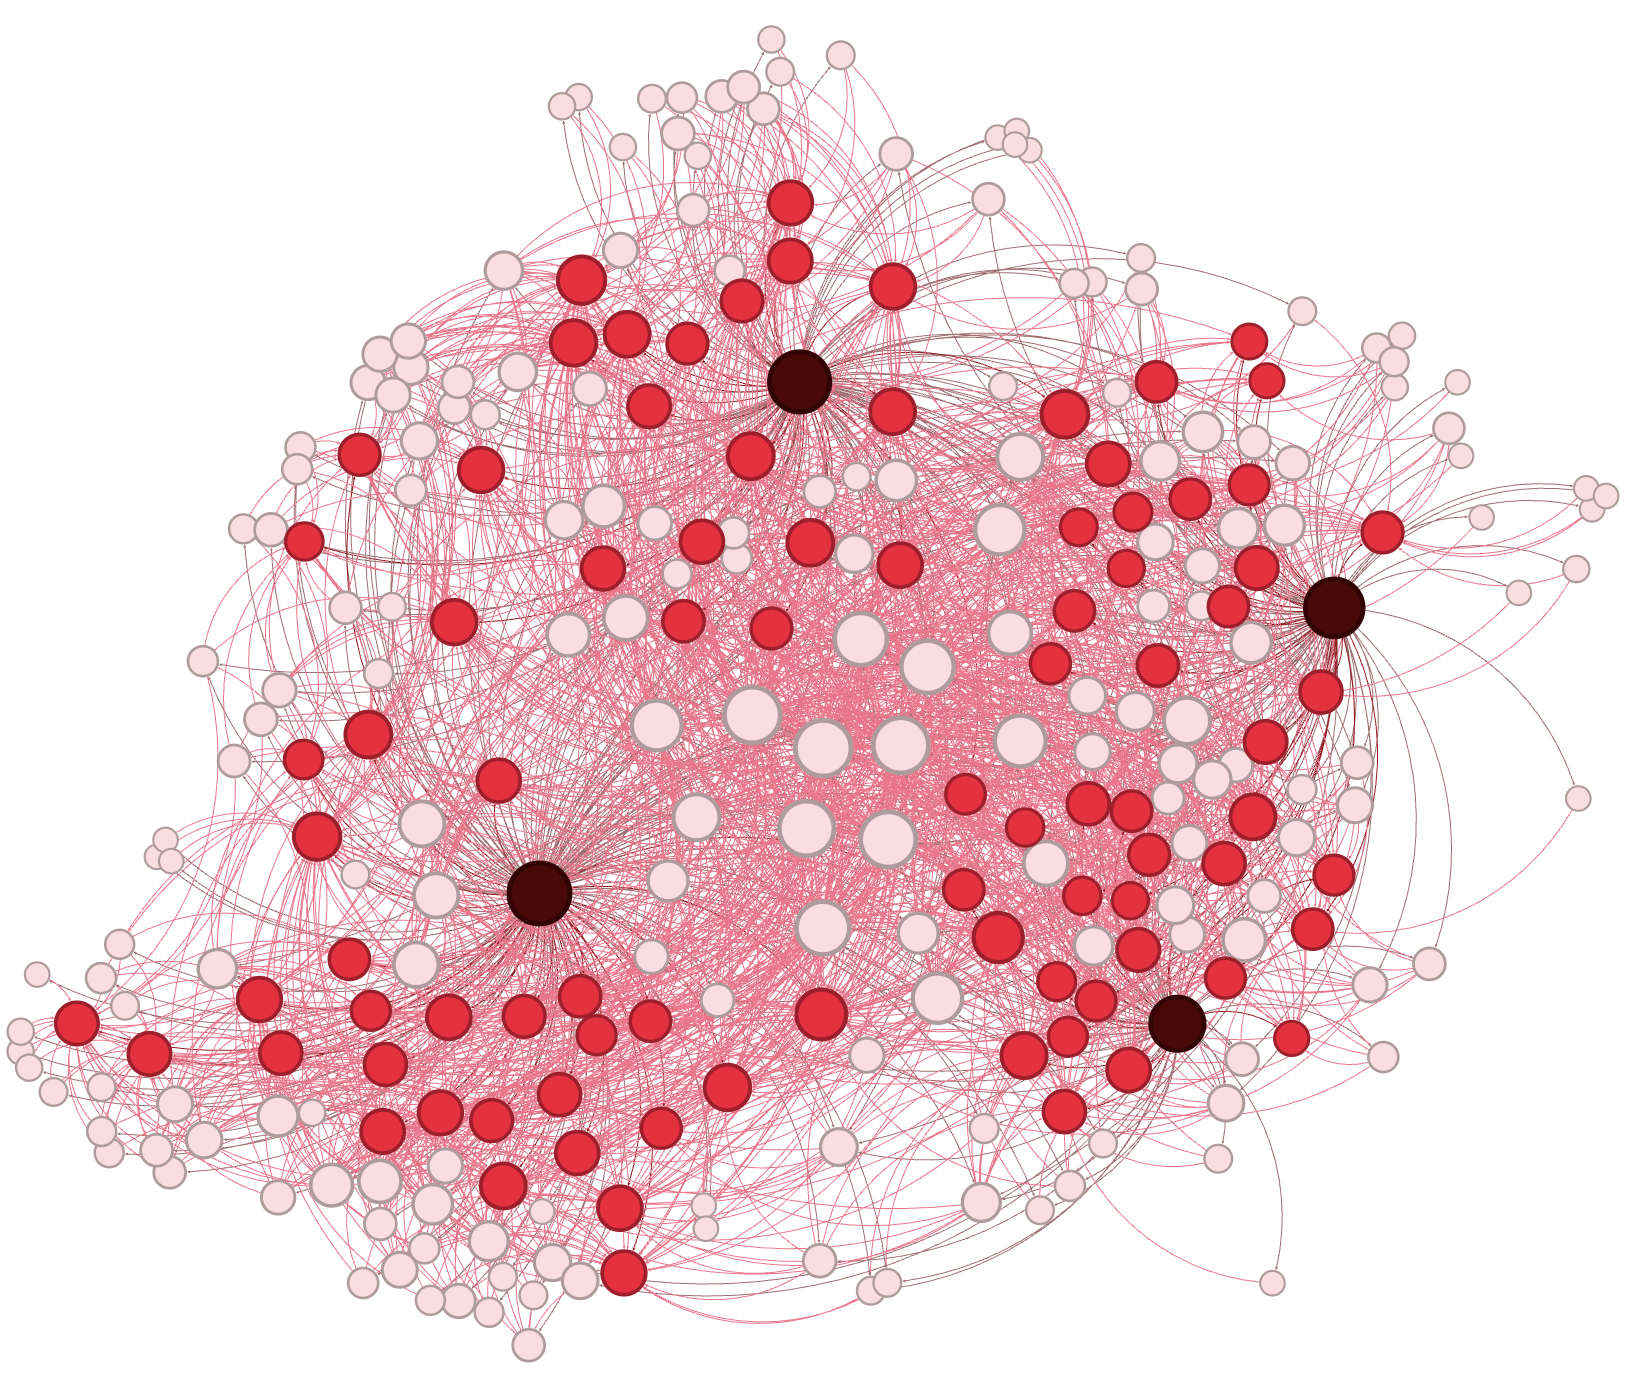

In [8]:
#display visualization of the gephi graph, which is the file graph.png
display(Image(filename="graph.png"))

In [10]:
# =========================================================
# Cell 4: Create Bipartite Subgraphs for Each Season
# =========================================================

def build_season_subgraph(df, season):
    # Create empty graph
    G_season = nx.Graph()
    
    # 1) Add season node
    season_node = f"Season {season}"
    G_season.add_node(season_node, layer="season", season_number=season)
    
    # 2) Find all characters that appear in this season
    season_chars = df[df["seasons"].apply(lambda s_list: season in s_list)]
    
    for _, row in season_chars.iterrows():
        char_name = row["name"]
        # Add character node
        G_season.add_node(char_name, layer="character")
        # Add edge (season, character)
        G_season.add_edge(season_node, char_name)
        
    # 3) For each character, gather episodes that fall into the given season
    #    Also keep track of all unique episodes in this season
    season_episodes = set()
    for _, row in season_chars.iterrows():
        char_name = row["name"]
        for ep_url in row["episodes"]:
            ep_num = get_episode_number(ep_url)
            if determine_season(ep_num) == season:
                # Add episode node
                ep_node = f"Episode {ep_num}"
                G_season.add_node(ep_node, layer="episode", episode_number=ep_num)
                season_episodes.add(ep_node)
                
                # Add edge (character, episode)
                G_season.add_edge(char_name, ep_node)
    
    # 4) Add edges (season, episode)
    for ep_node in season_episodes:
        G_season.add_edge(season_node, ep_node)
    
    return G_season

# Build subgraphs for each season
season_graphs = {}
for s in [1, 2, 3, 4]:
    subG = build_season_subgraph(df_cleaned, s)
    season_graphs[s] = subG
    print(f"Season {s} subgraph has {subG.number_of_nodes()} nodes and {subG.number_of_edges()} edges.")


Season 1 subgraph has 106 nodes and 598 edges.
Season 2 subgraph has 73 nodes and 345 edges.
Season 3 subgraph has 140 nodes and 780 edges.
Season 4 subgraph has 168 nodes and 972 edges.


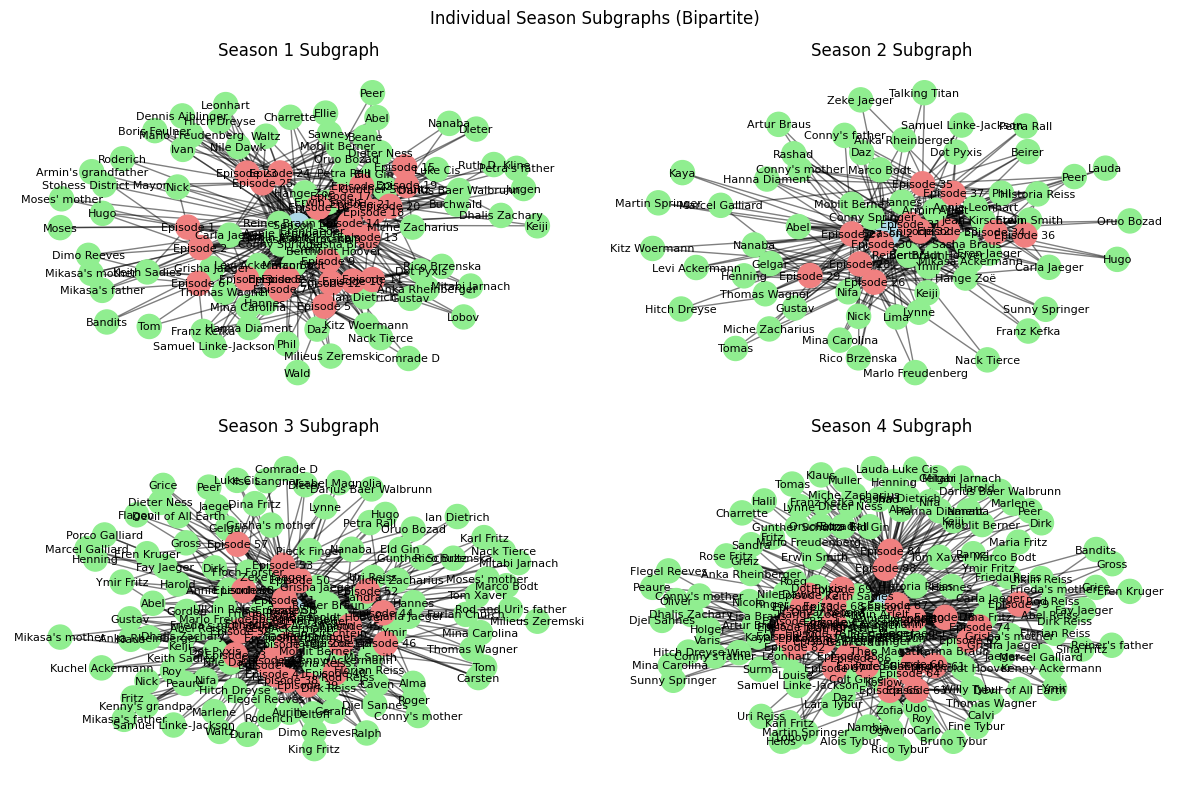

In [11]:
# =====================================================================
# Cell 4: Optional - Show All Subgraphs in a Single Figure with Subplots
# =====================================================================

def get_node_color(node, graph):
    """Assign a color based on the 'layer' attribute."""
    layer = graph.nodes[node].get("layer")
    if layer == "season":
        return "lightblue"
    elif layer == "character":
        return "lightgreen"
    elif layer == "episode":
        return "lightcoral"
    else:
        return "grey"

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Individual Season Subgraphs (Bipartite)")

season_list = [1, 2, 3, 4]

for idx, s in enumerate(season_list):
    ax = axes[idx // 2, idx % 2]
    G_s = season_graphs[s]
    
    # Use a layout algorithm, e.g. spring_layout or bipartite_layout
    # bipartite_layout requires you to specify two sets, which can be tricky here.
    # We'll just go with spring_layout for a quick aesthetic.
    pos = nx.spring_layout(G_s, seed=42)  # seed for reproducibility
    
    # Draw nodes with color
    node_colors = [get_node_color(n, G_s) for n in G_s.nodes()]
    nx.draw_networkx_nodes(G_s, pos, ax=ax, node_color=node_colors)
    
    # Draw edges
    nx.draw_networkx_edges(G_s, pos, ax=ax, alpha=0.5)
    
    # Draw labels
    nx.draw_networkx_labels(G_s, pos, ax=ax, font_size=8)
    
    ax.set_title(f"Season {s} Subgraph")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [12]:
# -- Connected Components Analysis --
# For an undirected graph, we can use:
#   nx.connected_components(G) to get the sets of nodes in each component.

components = list(nx.connected_components(G))
print(f"\nNumber of connected components: {len(components)}")

# Identify the largest connected component (by size of the set of nodes)
largest_cc = max(components, key=len)
print(f"Size of the largest connected component: {len(largest_cc)}")

# If you want to isolate the subgraph of the largest CC:
G_largest_cc = G.subgraph(largest_cc).copy()
print(f"Largest CC subgraph nodes: {G_largest_cc.number_of_nodes()}")
print(f"Largest CC subgraph edges: {G_largest_cc.number_of_edges()}")


Number of connected components: 10
Size of the largest connected component: 283
Largest CC subgraph nodes: 283
Largest CC subgraph edges: 2695


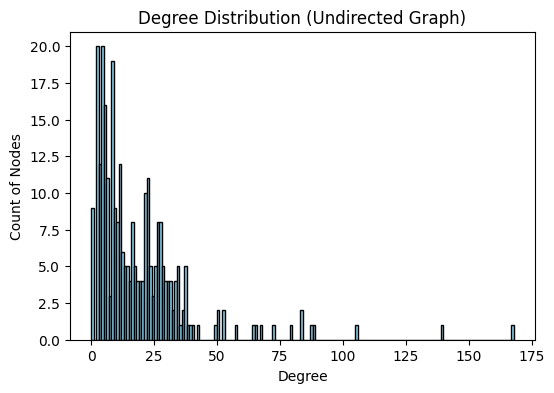

Min degree: 0
Max degree: 167
Mean degree: 18.46
Median degree: 13.00


In [13]:
# =============================================
# Cell 13: Degree Distribution of the Graph
# =============================================

"""
Now we'll examine the degree distribution. 
For an undirected graph, the 'degree' is the count of edges incident to each node.
For a directed graph, we'd have separate 'in_degree' and 'out_degree'.

We'll do a simple analysis on G (undirected).
- Collect all degrees
- Plot them or just do a tabular summary
- Possibly look at log-log plots to see if there's a heavy tail
"""

import matplotlib.pyplot as plt

# Get degrees of all nodes
degrees = [val for (node, val) in G.degree()]

# Let's do a quick histogram
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=range(min(degrees), max(degrees)+2), color="skyblue", edgecolor="black")
plt.title("Degree Distribution (Undirected Graph)")
plt.xlabel("Degree")
plt.ylabel("Count of Nodes")
plt.show()

# We can also inspect min/max/mean
import statistics
print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Mean degree: {statistics.mean(degrees):.2f}")
print(f"Median degree: {statistics.median(degrees):.2f}")


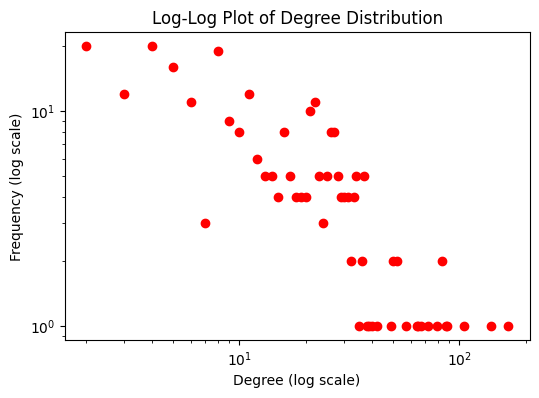

Calculating best minimal value for power law fit
Power law alpha: 3.5408127156966955
Power law xmin: 25.0
Comparing power law vs. exponential -> R:  9.535696933759827 , p-value:  0.010164029263277191


Values less than or equal to 0 in data. Throwing out 0 or negative values


'\nInterpretation:\n- If alpha is between ~2 and 3, that indicates a heavy-tailed, possibly scale-free distribution.\n- A high p-value (and positive R) for the comparison might indicate that \n  power_law is a better fit than exponential or other distributions.\n'

In [14]:
# ===========================================================
# Cell 14: Checking for Power Law (Scale-Free) Distribution
# ===========================================================

"""
We can see if the degree distribution roughly follows a power law (a hallmark of scale-free networks).
One approach is to:
    - Plot the degree distribution on a log-log scale
    - Possibly use an external library like 'powerlaw' to fit a power law and test.

Below is a simpler demonstration: we'll do a quick log-log plot of the degree distribution.
Optionally, you can install powerlaw library and run a formal test.
"""

# We'll do a quick log-log plot.
import numpy as np

degree_values = sorted(degrees)
counts = {}
for d in degree_values:
    counts[d] = counts.get(d, 0) + 1

x = np.array(list(counts.keys()), dtype=float)
y = np.array(list(counts.values()), dtype=float)

plt.figure(figsize=(6,4))
plt.loglog(x, y, marker='o', linestyle='None', color='red')
plt.title("Log-Log Plot of Degree Distribution")
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.show()

# [Optional] If you want to do a quick naive check:
# We could approximate a slope by linear regression in log-log space,
# or do a more robust test with powerlaw package.

import powerlaw
fit = powerlaw.Fit(degree_values)
print("Power law alpha:", fit.alpha)
print("Power law xmin:", fit.xmin)
R, p = fit.distribution_compare('power_law', 'exponential')
print("Comparing power law vs. exponential -> R: ", R, ", p-value: ", p)

"""
Interpretation:
- If alpha is between ~2 and 3, that indicates a heavy-tailed, possibly scale-free distribution.
- A high p-value (and positive R) for the comparison might indicate that 
  power_law is a better fit than exponential or other distributions.
"""


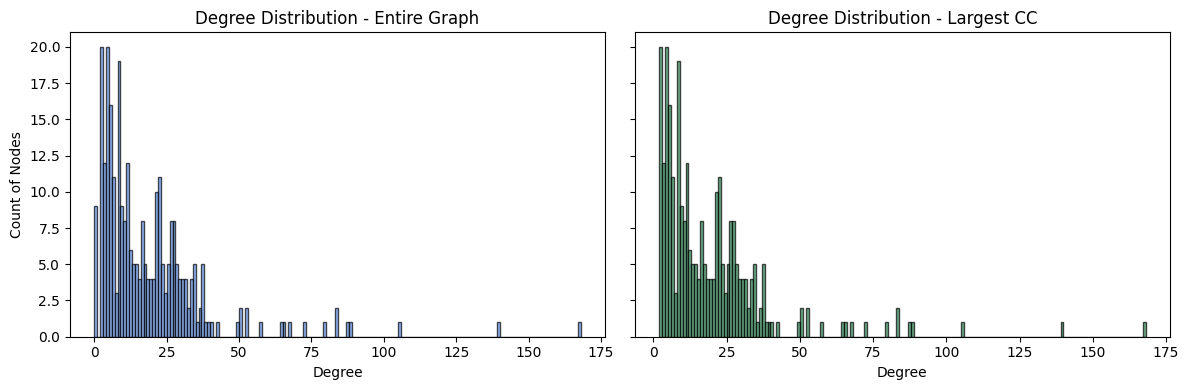

=== Entire Graph ===
  Min degree:   0
  Max degree:   167
  Mean degree:  18.46
  Median degree:13.00

=== Largest CC ===
  Min degree:   2
  Max degree:   167
  Mean degree:  19.05
  Median degree:14.00


In [15]:
# ==============================================
# Cell 15: Compare Degree Distribution (Full vs LCC)
# ==============================================

import matplotlib.pyplot as plt
import statistics

# -- Degrees in the full graph --
degrees_full = [deg for _, deg in G.degree()]
min_full, max_full = min(degrees_full), max(degrees_full)
mean_full = statistics.mean(degrees_full)
median_full = statistics.median(degrees_full)

# -- Degrees in the largest connected component --
# (G_largest_cc was computed in Cell 12; if not, recompute below)
# largest_cc = max(nx.connected_components(G), key=len)
# G_largest_cc = G.subgraph(largest_cc).copy()

degrees_lcc = [deg for _, deg in G_largest_cc.degree()]
min_lcc, max_lcc = min(degrees_lcc), max(degrees_lcc)
mean_lcc = statistics.mean(degrees_lcc)
median_lcc = statistics.median(degrees_lcc)

# --- Side-by-side histograms ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Histogram bins:
full_bins = range(min_full, max_full + 2)
lcc_bins = range(min_lcc, max_lcc + 2)

axes[0].hist(degrees_full, bins=full_bins, color="cornflowerblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Degree Distribution - Entire Graph")
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Count of Nodes")

axes[1].hist(degrees_lcc, bins=lcc_bins, color="seagreen", edgecolor="black", alpha=0.7)
axes[1].set_title("Degree Distribution - Largest CC")
axes[1].set_xlabel("Degree")
# The y-axis label is shared due to sharey=True

plt.tight_layout()
plt.show()

# --- Print Basic Stats ---
print("=== Entire Graph ===")
print(f"  Min degree:   {min_full}")
print(f"  Max degree:   {max_full}")
print(f"  Mean degree:  {mean_full:.2f}")
print(f"  Median degree:{median_full:.2f}")
print()
print("=== Largest CC ===")
print(f"  Min degree:   {min_lcc}")
print(f"  Max degree:   {max_lcc}")
print(f"  Mean degree:  {mean_lcc:.2f}")
print(f"  Median degree:{median_lcc:.2f}")


======================================
# Cell 16 (Markdown): 2. Advanced Metrics
======================================

In this section, we explore advanced network metrics to gain deeper insights.

#### 2.1 Centrality Analysis
    - We'll compute closeness centrality and Katz centrality (alongside degree, betweenness, etc. if desired).
    - Then we compare which characters, episodes, or seasons rank highest under each measure.
    - We also highlight differences across seasons if relevant.

#### 2.2 Higher-Order Network Measures
    - We'll compute edge betweenness centrality to see which edges are critical bridges.
    - We'll discuss motif detection or subgraph patterns to identify recurring interaction structures.

Let's proceed with code cells that implement these steps.


In [16]:
# =============================================================
# Cell 17: 2.1 Centrality Analysis - Closeness and Katz
# =============================================================
# We assume G is our main undirected tripartite graph.

# --- Closeness Centrality ---
closeness = nx.closeness_centrality(G)
# closeness is a dict: {node: closeness_value, ...}

# --- Katz Centrality ---
# Katz centrality typically requires a directed graph or an alpha less than 1/largest_eigenvalue(A).
# NetworkX can still compute it on an undirected graph by treating edges as two-directed.
# We'll pick a small alpha (attenuation factor). 
# If alpha is too large, the iteration may not converge.
try:
    katz = nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0)  # or nx.katz_centrality(G, alpha=0.01)
except nx.PowerIterationFailedConvergence:
    print("Katz centrality did not converge with alpha=0.01, please lower alpha or adjust parameters.")
    katz = None

# (Optional) If you had a directed version (G_directed), you could do:
# katz_directed = nx.katz_centrality_numpy(G_directed, alpha=0.01, beta=1.0)

# Sort by closeness or Katz to see top nodes
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_katz = []
if katz is not None:
    sorted_katz = sorted(katz.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Closeness Centrality ===")
for node, val in sorted_closeness:
    print(f"{node:25s} -> {val:.4f}")

print("\n=== Top 10 Nodes by Katz Centrality ===")
for node, val in sorted_katz:
    print(f"{node:25s} -> {val:.4f}")


=== Top 10 Nodes by Closeness Centrality ===
Season 4                  -> 0.6073
Eren Jaeger               -> 0.5741
Mikasa Ackermann          -> 0.5729
Armin Arlelt              -> 0.5681
Conny Springer            -> 0.5681
Jean Kirschtein           -> 0.5635
Reiner Braun              -> 0.5499
Season 3                  -> 0.5477
Sasha Braus               -> 0.5477
Hange Zoë                 -> 0.5466

=== Top 10 Nodes by Katz Centrality ===
Season 4                  -> 0.1404
Season 3                  -> 0.1253
Season 1                  -> 0.1061
Eren Jaeger               -> 0.1013
Mikasa Ackermann          -> 0.1010
Conny Springer            -> 0.0987
Armin Arlelt              -> 0.0986
Jean Kirschtein           -> 0.0965
Season 2                  -> 0.0890
Reiner Braun              -> 0.0887


=============================================================
# Cell 18 (Markdown): Centrality Comparison & Observations
=============================================================

In practice, we would do a comparative analysis across:
  - Degree Centrality (already partly examined via degrees)
  - Betweenness Centrality
  - Closeness Centrality
  - Katz Centrality
  - Possibly Eigenvector Centrality, PageRank, etc.

We can produce a small table or DataFrame that merges the values of these 
centralities for each node and then identify interesting patterns or characters
that are not the main protagonists but still rank highly.

Additionally, if we wanted to highlight differences across *seasons*, 
we might restrict G to each season subgraph (like we did earlier) 
and compute these metrics season by season.

Let's see an example of betweenness and then we'll gather everything in a DataFrame.


In [17]:
# ==========================================================
# Cell 19: 2.2 Higher-Order Measures - Edge Betweenness
# ==========================================================

# Edge betweenness centrality identifies edges that lie on many shortest paths 
# and thus act as critical bridges.

edge_betw = nx.edge_betweenness_centrality(G)

# Show top 10 edges by betweenness
sorted_edge_betw = sorted(edge_betw.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Edges by Betweenness Centrality ===")
for (u, v), val in sorted_edge_betw:
    print(f"({u} -- {v}): {val:.4f}")


=== Top 10 Edges by Betweenness Centrality ===
(Season 4 -- Helos): 0.0061
(Season 4 -- Reiner's father): 0.0057
(Season 4 -- Sina Fritz): 0.0055
(Season 4 -- Rose Fritz): 0.0055
(Season 4 -- Maria Fritz): 0.0055
(Season 4 -- Alois Tybur): 0.0055
(Season 4 -- Bruno Tybur): 0.0055
(Season 4 -- Rico Tybur): 0.0055
(Season 1 -- Moses): 0.0054
(Season 1 -- Wald): 0.0052


In [18]:
# ============================================================
# Cell 20: 2.2 Higher-Order Measures - Motif/Subgraph Patterns
# ============================================================

"""
Identifying motifs or small recurring subgraph patterns can be done in multiple ways.
A basic approach might be to look for triads or 4-node patterns that appear frequently.

For small motif detection, we can do:
  - networkx.algorithms.isomorphism (subgraph_isomorphisms) 
  - or use a specialized library if we want frequent subgraph mining.

Below is a simple example checking for triangles in the graph (3-cycle).
However, since our graph is tripartite in nature, genuine 3-cycles might be rare or impossible.
You might want to check for squares or specific bipartite motifs.
"""

# Let's try a simple approach for counting triangles in an undirected graph:
triangles = nx.triangles(G)  # returns dict: node -> count of triangles that node is part of
# The total number of triangles can be computed by summing this up / 3
total_triangles = sum(triangles.values()) / 3
print(f"Number of triangles found in G: {int(total_triangles)}")

# For other motifs (like squares), you'd do more specialized checks. 
# E.g., searching for 4-cycles in a bipartite graph. 
# This is more advanced and can be done with BFS expansions or specialized subgraph search.


Number of triangles found in G: 2212


===============================================
# Cell 21 (Markdown): 3. Temporal Dynamics
===============================================

Next, we expand on dynamic aspects. 
Instead of the simplistic SI model, let's do an SIR model (Susceptible-Infected-Recovered).
The SIR model allows infected nodes to recover and no longer participate in the infection 
process, which is more realistic for certain types of "information" or "disease" spread.

We'll do the following:
 - Initialize a fraction of nodes as 'Infected' (I), the rest as 'Susceptible' (S).
 - At each time step, infected nodes may infect their neighbors with probability p_infect.
 - Infected nodes may recover with probability p_recover and transition to state R (Recovered).
 - We'll track the number of S, I, R nodes over time and plot them.

Finally, we can compare these results with episode-specific subgraphs (temporal slicing),
e.g., building a time-ordered view of the network so that edges only exist for episodes 
up to certain points, etc.


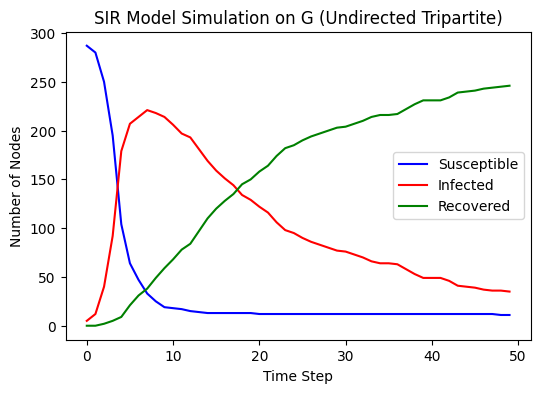

Final counts after simulation:
  Susceptible: 11
  Infected:    35
  Recovered:   246


In [19]:
# ==================================================
# Cell 22: 3.1 SIR Model Simulation (Basic Example)
# ==================================================

import random
import matplotlib.pyplot as plt

def sir_simulation(G, p_infect=0.1, p_recover=0.05, initial_infected_fraction=0.01, max_steps=50):
    """
    Basic SIR simulation on an undirected graph G.
    - p_infect: Probability an infected node infects a susceptible neighbor per step.
    - p_recover: Probability an infected node recovers at each step.
    - initial_infected_fraction: fraction of nodes to set as infected at t=0.
    - max_steps: max number of iterations to simulate.
    Returns:
      S_list, I_list, R_list: time series of susceptible, infected, recovered counts.
    """
    # States: "S", "I", "R"
    nodes = list(G.nodes())
    N = len(nodes)
    
    # Initialize states
    state = {}
    for n in nodes:
        state[n] = "S"
    
    # Infect some fraction of nodes
    infected_count = int(initial_infected_fraction * N)
    initial_infected = random.sample(nodes, infected_count)
    for n in initial_infected:
        state[n] = "I"
    
    S_list = []
    I_list = []
    R_list = []

    for step in range(max_steps):
        # Count states
        S_count = sum(1 for n in nodes if state[n] == "S")
        I_count = sum(1 for n in nodes if state[n] == "I")
        R_count = sum(1 for n in nodes if state[n] == "R")
        
        S_list.append(S_count)
        I_list.append(I_count)
        R_list.append(R_count)
        
        if I_count == 0:
            # no more infected => epidemic ends
            break
        
        # Prepare to update states
        new_state = state.copy()
        
        # Infect neighbors
        for n in nodes:
            if state[n] == "I":
                # Attempt to infect neighbors
                for neighbor in G.neighbors(n):
                    if state[neighbor] == "S":
                        if random.random() < p_infect:
                            new_state[neighbor] = "I"
        
        # Recover
        for n in nodes:
            if state[n] == "I":
                if random.random() < p_recover:
                    new_state[n] = "R"
        
        state = new_state
    
    return S_list, I_list, R_list

# Let's run a quick example. 
# NOTE: Each run will differ due to random sampling, so you can set a random seed for reproducibility.
S_list, I_list, R_list = sir_simulation(G, p_infect=0.1, p_recover=0.05, initial_infected_fraction=0.02, max_steps=50)

plt.figure(figsize=(6,4))
plt.plot(S_list, label="Susceptible", color="blue")
plt.plot(I_list, label="Infected", color="red")
plt.plot(R_list, label="Recovered", color="green")
plt.xlabel("Time Step")
plt.ylabel("Number of Nodes")
plt.title("SIR Model Simulation on G (Undirected Tripartite)")
plt.legend()
plt.show()

print("Final counts after simulation:")
print(f"  Susceptible: {S_list[-1]}")
print(f"  Infected:    {I_list[-1]}")
print(f"  Recovered:   {R_list[-1]}")


===============================================
# Cell 24 (Markdown): Why We Used an SIR Model
===============================================

**Why SIR for an Anime Character Network?**

We chose a Susceptible-Infected-Recovered (SIR) model for 'information spread' because:
1. **Temporary state**: Characters (or nodes) that 'recover' from certain information or
   event (e.g., they are no longer actively disseminating it).
2. **Realistic simulation**: In an anime context, a rumor/event may eventually die out 
   for a given character (they 'recover'), making SIR more appropriate than an SI model 
   (where once infected, a node remains infected forever).
3. **Analogy to storyline arcs**: Characters can be heavily involved in a plot (infected), 
   then move on (recover) while other characters remain unaffected, until bridging episodes 
   bring them back in. This mimics how storylines appear and resolve.
Thus, the SIR model captures transient involvement in a storyline or 'infection' 
better than the perpetual infection assumption in the SI model.


Calculating best minimal value for power law fit
Power-law fit results:
  alpha=3.211, xmin=21.0

Comparing Power Law vs. Exponential:
  R=1.803, p=0.071
  (R>0 => PL better fit, R<0 => EXP better fit)

Comparing Power Law vs. Lognormal:
  R=-0.351, p=0.725


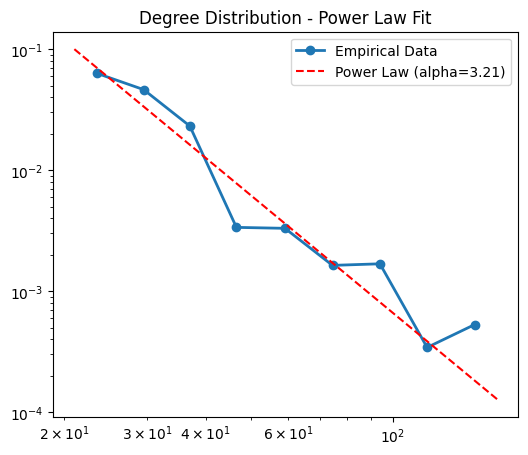

"\nInterpretation:\n- alpha between ~2 and 3 often indicates a heavy-tailed, scale-free-like distribution.\n- If R > 0 and p < 0.05 in distribution_compare, it suggests the first distribution \n  is significantly a better fit than the second. \n- If results are mixed (or p is large), there's no conclusive difference.\n"

In [20]:
# ===================================================
# Cell 25: 4. Power Law and Degree Distribution
# ===================================================

# We now formally test whether the degree distribution of G (undirected) 
# follows a power law, using the "powerlaw" library.

# If you haven't installed powerlaw, uncomment and run:
# !pip install powerlaw


# We'll gather the degrees from G
degrees = [deg for _, deg in G.degree() if deg > 0]  # exclude isolated if any

# Fit a power law using powerlaw
fit = powerlaw.Fit(degrees, discrete=True)
alpha = fit.alpha
xmin = fit.xmin

print(f"Power-law fit results:\n  alpha={alpha:.3f}, xmin={xmin}")

# Compare power law with other distributions, e.g. exponential, lognormal
R_exp, p_exp = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
R_logn, p_logn = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

print("\nComparing Power Law vs. Exponential:")
print(f"  R={R_exp:.3f}, p={p_exp:.3f}")
print("  (R>0 => PL better fit, R<0 => EXP better fit)")

print("\nComparing Power Law vs. Lognormal:")
print(f"  R={R_logn:.3f}, p={p_logn:.3f}")

# Quick visual
plt.figure(figsize=(6,5))
fit.plot_pdf(label='Empirical Data', linewidth=2, marker='o')
fit.power_law.plot_pdf(label=f'Power Law (alpha={fit.alpha:.2f})', color='r', linestyle='--')
plt.legend()
plt.title("Degree Distribution - Power Law Fit")
plt.show()

"""
Interpretation:
- alpha between ~2 and 3 often indicates a heavy-tailed, scale-free-like distribution.
- If R > 0 and p < 0.05 in distribution_compare, it suggests the first distribution 
  is significantly a better fit than the second. 
- If results are mixed (or p is large), there's no conclusive difference.
"""


=======================================================
Cell 26 (Markdown): Interpreting the Power Law Results
=======================================================

From the output of powerlaw:
- We get an estimate of alpha for the power law.
- We compare it to other distributions (exponential, lognormal) via the R statistic and p-values.

If R is positive and p < 0.05 for "power_law vs. exponential", 
it suggests the power law is a better fit than exponential. 
Similarly for lognormal.

For an anime-character network, it might or might not be truly scale-free, 
but a heavy-tailed distribution is quite common: 
a few characters or episodes have many connections, 
while most have far fewer. 
This can reflect the storyline focusing on certain major nodes ("hubs").

Next, we'll move on to point 5: advanced community detection and role assignment.


In [21]:
# =====================================================================
# Cell 27: 5. Community Detection (Infomap & Louvain) and Visualization
# =====================================================================

from cdlib import algorithms

def print_partition_summary(partition):
    """
    Print a simple summary for a cdlib NodeClustering object.
    partition.communities -> list of lists, each list is a community of nodes.
    partition.method_name -> name of the algorithm.
    """
    print(f"Method: {partition.method_name}")
    print(f"Number of communities: {len(partition.communities)}")
    
    sizes = [len(c) for c in partition.communities]
    print(f"Community sizes: {sizes}")
    # If you want the actual node sets, you can do:
    # print("Communities:", partition.communities)
    print()

# --- Infomap ---
infomap_comm = algorithms.infomap(G)  # Infomap on an undirected graph
print("=== Infomap ===")
print_partition_summary(infomap_comm)

# --- Louvain ---
louvain_comm = algorithms.louvain(G)
print("=== Louvain ===")
print_partition_summary(louvain_comm)


=== Infomap ===
Method: Infomap
Number of communities: 10
Community sizes: [283, 1, 1, 1, 1, 1, 1, 1, 1, 1]

=== Louvain ===
Method: Louvain
Number of communities: 13
Community sizes: [85, 71, 67, 60, 1, 1, 1, 1, 1, 1, 1, 1, 1]



==========================================================================
#Cell 28 (Markdown): Node Roles - Hubs, Connectors, Periphery
==========================================================================

After detecting communities, we can classify nodes into roles such as:
  - Hub: a node with high degree or high centrality within its community.
  - Connector: a node that links multiple communities (bridging node).
  - Periphery: a node with few edges or minor roles in the network.

One approach is:
  1) Identify the community each node belongs to (e.g., from Louvain).
  2) For each node, compute its in-community degree (within the node's assigned community)
     vs. out-of-community degree. 
  3) High in-community degree or high betweenness bridging communities => "hub" or "connector".
  4) Low in-community degree => potential "periphery".

We can also use "community role" frameworks (e.g. Guimerà and Amaral, 2005) 
or bridging centrality measures. 
Below is a code snippet that shows a simple method for identifying bridging nodes 
and high-degree hubs.


In [22]:
# ============================================
# Cell 29: Simple Role Assignment Example
# ============================================

import pandas as pd

def assign_communities_to_nodes(G, communities):
    """
    communities: list of lists, each sub-list is a group of node IDs forming one community.
    Returns: dict {node: community_index}
    """
    node2comm = {}
    for i, c_group in enumerate(communities):
        for node in c_group:
            node2comm[node] = i
    return node2comm

# We'll pick the Louvain partition as an example
node2comm = assign_communities_to_nodes(G, louvain_comm.communities)

# Compute "in-community degree" and "out-of-community degree" for each node
in_deg = {}
out_deg = {}
for node in G.nodes():
    in_deg[node] = 0
    out_deg[node] = 0

    node_comm = node2comm[node]
    neighbors = G.neighbors(node)
    for nbr in neighbors:
        if node2comm[nbr] == node_comm:
            in_deg[node] += 1
        else:
            out_deg[node] += 1

# We can define simple thresholds for roles
# e.g. "hub" if in_deg[node] is in top X percentile, "connector" if out_deg[node] is high, etc.
# For demonstration, let's define arbitrary thresholds:

in_deg_values = list(in_deg.values())
out_deg_values = list(out_deg.values())

threshold_in = np.percentile(in_deg_values, 90)   # top 10%
threshold_out = np.percentile(out_deg_values, 90) # top 10%

roles = {}
for node in G.nodes():
    if in_deg[node] >= threshold_in:
        roles[node] = "Hub"
    elif out_deg[node] >= threshold_out:
        roles[node] = "Connector"
    else:
        roles[node] = "Periphery"

# Create a small DataFrame to inspect
role_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Community': [node2comm[n] for n in G.nodes()],
    'In_Comm_Deg': [in_deg[n] for n in G.nodes()],
    'Out_Comm_Deg': [out_deg[n] for n in G.nodes()],
    'Role': [roles[n] for n in G.nodes()]
})
role_df.sort_values("Role", inplace=True)  # Just to group roles
role_df.head(20)


,Node,Community,In_Comm_Deg,Out_Comm_Deg,Role
291,Episode 88,3,14,38,Connector
163,Carla Jaeger,3,6,22,Connector
190,Eren Jaeger,3,17,71,Connector
25,Moblit Berner,1,13,24,Connector
247,Episode 44,2,17,20,Connector
252,Episode 49,2,15,22,Connector
254,Episode 51,1,12,19,Connector
256,Episode 53,3,15,25,Connector
261,Episode 58,2,13,20,Connector
15,Erwin Smith,3,14,36,Connector


================================================
# Cell 30 (Markdown): Discussion of Role Analysis
================================================

We see a rough classification (Hub, Connector, Periphery) based on 
in-community vs. out-of-community degrees. 
More sophisticated approaches might:
  - Use z-scores for in-community degree vs. the average in-community degree 
    (the "Z" measure).
  - Use the Participation Coefficient for out-of-community edges (the "P" measure).
  - Combine these for a well-known classification into roles such as:
      - Ultra-peripheral (low Z, low P)
      - Connector hub (high Z, high P)
      - Provincial hub (high Z, low P)
      - etc.
That concludes points (4) and (5), demonstrating advanced power-law analysis, 
community detection (Infomap & Louvain), and basic role assignment in the network.

Next steps would involve analyzing:
  - 6. Dynamic Changes Across Seasons
  - 7. Advanced Link Prediction
  - 8. Visual Enhancements and Exports
in a similar cell-by-cell manner, building upon the insights gained here.


In [23]:
season_subgraphs = {}
for s in [1, 2, 3, 4]:
    subG = build_season_subgraph(df_cleaned, s)
    season_subgraphs[s] = subG
def jaccard_index_edges(Ga, Gb):
    Ea = set(Ga.edges())
    Eb = set(Gb.edges())
    inter = Ea.intersection(Eb)
    union = Ea.union(Eb)
    if len(union) == 0:
        return 0.0
    return len(inter)/len(union)

for s in [1, 2, 3]:
    j = jaccard_index_edges(season_subgraphs[s], season_subgraphs[s+1])
    print(f"Jaccard index between Season {s} and {s+1}: {j:.3f}")

Jaccard index between Season 1 and 2: 0.000
Jaccard index between Season 2 and 3: 0.000
Jaccard index between Season 3 and 4: 0.000


In [24]:
# =======================================
# Cell 34 (Markdown): 7. Advanced Link Prediction
# =======================================

# Now we move on to advanced link prediction. 
# The idea: we want to predict potential future interactions 
# (e.g., which characters might appear together in a future episode).
#
# We can use:
#   - Traditional link prediction heuristics (Common Neighbors, Adamic-Adar, etc.).
#   - Embedding-based methods (Node2Vec or other node embeddings). 
#     Then train a supervised model (e.g., logistic regression) to predict edges.
#
# We'll demonstrate a simple Node2Vec approach from the library 'node2vec' 
# or 'stellargraph' if you have it installed. We'll do a minimal illustration.


In [25]:
# ===================================================
# Cell 35: Node2Vec Embeddings + Supervised Example
# ===================================================

# If not installed, do:
# !pip install node2vec

import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Build/Use the existing graph G (the tripartite undirected).
#    We'll get an embedding for each node.

node2vec = Node2Vec(G, dimensions=16, walk_length=10, num_walks=100, workers=1, seed=42)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# 2. Prepare "positive edges" (existing edges in G)
#    and sample "negative edges" (pairs of nodes not connected) for training.
edges = list(G.edges())
X_pos = []
for (u, v) in edges:
    emb_u = model.wv.get_vector(u)
    emb_v = model.wv.get_vector(v)
    # simple approach: combine by elementwise multiplication or concat
    X_pos.append(emb_u * emb_v)

# Sample negative edges
# naive approach: pick random pairs that are not edges
all_nodes = list(G.nodes())
non_edges = []
while len(non_edges) < len(edges):
    a, b = np.random.choice(all_nodes, 2, replace=False)
    if not G.has_edge(a, b):
        non_edges.append((a,b))

X_neg = []
for (u, v) in non_edges:
    emb_u = model.wv.get_vector(u)
    emb_v = model.wv.get_vector(v)
    X_neg.append(emb_u * emb_v)

# 3. Labels: 1 for positive edges, 0 for negative
y_pos = [1]*len(X_pos)
y_neg = [0]*len(X_neg)

X = np.vstack((X_pos, X_neg))
y = np.hstack((y_pos, y_neg))

# 4. Train/test split + random forest example
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

acc = clf.score(X_test, y_test)
print(f"Link Prediction Accuracy: {acc:.3f}")

"""
You can then use the trained model to predict potential new edges (not in G),
examine top-scoring pairs to see which character-episode or character-character 
links might be most likely in future expansions of the anime storyline.
"""


Computing transition probabilities:   0%|          | 0/292 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 131.75it/s]


Link Prediction Accuracy: 0.852


'\nYou can then use the trained model to predict potential new edges (not in G),\nexamine top-scoring pairs to see which character-episode or character-character \nlinks might be most likely in future expansions of the anime storyline.\n'

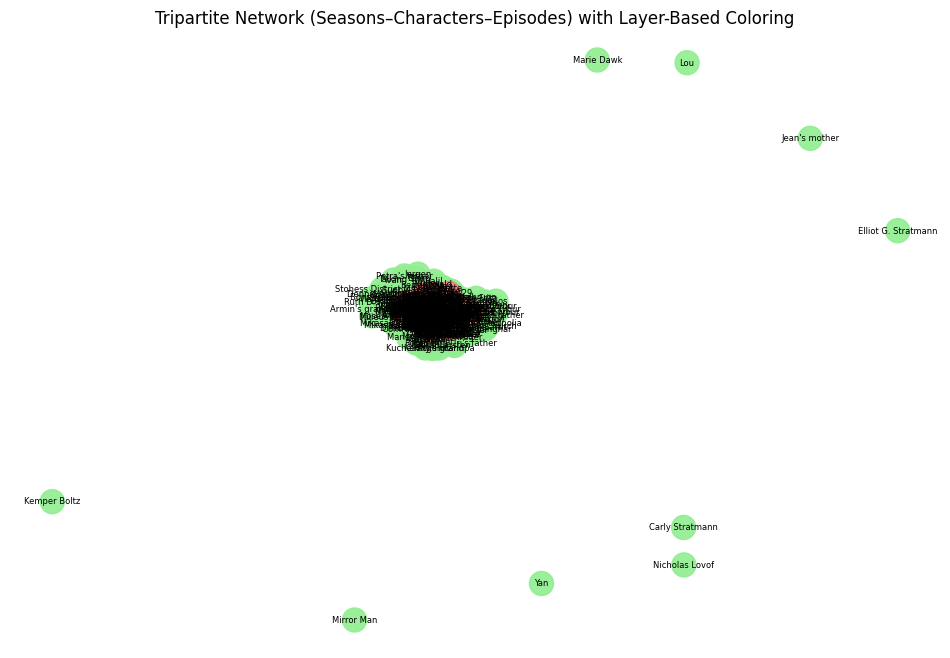

Exported to 'anime_tripartite_graph.gexf' for advanced analysis in Gephi.


In [26]:
# =============================================================
# Cell 37: Advanced Visualization & Export Example
# =============================================================

import matplotlib.pyplot as plt

# 1) Color by layer in a networkx + matplotlib plot
def get_layer_color(node, graph):
    layer = graph.nodes[node].get("layer", "")
    if layer == "season":
        return "lightblue"
    elif layer == "character":
        return "lightgreen"
    elif layer == "episode":
        return "lightcoral"
    else:
        return "grey"

pos = nx.spring_layout(G, seed=42)
node_colors = [get_layer_color(n, G) for n in G.nodes()]

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=6)
plt.title("Tripartite Network (Seasons–Characters–Episodes) with Layer-Based Coloring")
plt.axis('off')
plt.show()

# 2) Export to GEXF (Gephi-friendly). Also possible: .graphml, .gml, etc.
nx.write_gexf(G, "anime_tripartite_graph.gexf")
print("Exported to 'anime_tripartite_graph.gexf' for advanced analysis in Gephi.")


===================================
Cell 38 (Markdown): Final Remarks
===================================

We've now demonstrated:
(6) Dynamic Changes Across Seasons:
    - Subgraphs for each season
    - Jaccard similarity measure for consecutive seasons
    - Potential for animated or time-based visualization
(7) Advanced Link Prediction:
    - Node2Vec embeddings
    - Simple supervised classifier for edge existence

(8) Visual Enhancements and Exports:
    - Layer-based coloring with NetworkX
    - Export to GEXF for Gephi

Additional expansions:
  - Enhanced link prediction metrics
  - Integration of dynamic community detection 
  - Automatic generation of summary reports

Through these points, we've built a comprehensive pipeline 
to analyze and visualize the anime Seasons–Characters–Episodes network 
in both static and dynamic contexts.
